# Med MNIST

### Data Loading && Prepare

In [1]:
!pip3 install torch tqdm torchsummary torchvision fastprogress matplotlib pandas scikit-learn torchmetrics timm numpy albumentations scikit-image --quiet

In [2]:
import pandas as pd
import os

In [3]:
path = "./MedMNIST"
classes = os.listdir(path)
print(classes)

['Hand', 'BreastMRI', 'ChestCT', 'HeadCT', 'AbdomenCT', 'CXR']


In [4]:
import torch

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
dataset=ImageFolder(path,ToTensor())
dataset

Dataset ImageFolder
    Number of datapoints: 58954
    Root location: ./MedMNIST
    StandardTransform
Transform: ToTensor()

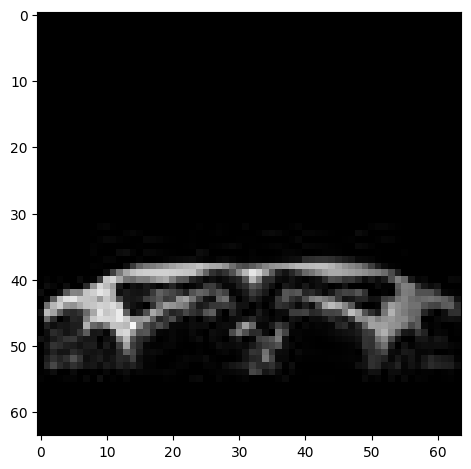

In [7]:
import matplotlib.pyplot as plt
import skimage.io as io
io.imshow('./MedMNIST/BreastMRI/000010.jpeg');

In [8]:
train_set,test_set,valid_set=torch.utils.data.random_split(dataset,[50000,6000,2954])

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, shuffle=True,batch_size = 16)
test_loader = DataLoader(test_set, batch_size = 16)
valid_loader = DataLoader(valid_set, batch_size = 16)

In [10]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

In [11]:
import timm
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np

/Users/evakhromeeva/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/evakhromeeva/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
num_classes = len(classes)
print(num_classes)

model = timm.create_model('resnet34', pretrained=True, num_classes=num_classes)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

6


In [13]:
model.to(device)
print('Done')

Done


In [ ]:
from torchmetrics.classification.roc import MulticlassROC

MClsROC = MulticlassROC(num_classes=num_classes)
Accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
Precision = MulticlassPrecision(num_classes=num_classes).to(device)
Recall = MulticlassRecall(num_classes=num_classes).to(device)


In [18]:
for e in range(2):
    print(f"Epoch: {e + 1}")
    loss_train = []
    loss_test = []
    mcls_test = []
    model.train()
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        predict = model(x)
        l = loss_f(predict, y)
        l.backward()
        loss_train.append(float(l.item()))
        optimizer.step()

        Accuracy.update(predict, y)
        Precision.update(predict, y)
        Recall.update(predict, y)
        MClsROC.update(predict, y)
        mcls_test.append(MClsROC.compute())
    print("Acc: ", Accuracy.compute())
    print("Prec: ", Precision.compute())
    print("Rec: ", Recall.compute())

    print(np.mean(loss_train))
    model.eval()
    for x, y in tqdm(test_loader):
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            predict = model(x)
            l = loss_f(predict, y)
            loss_test.append(float(l.item()))
            Accuracy.update(predict, y)
            Precision.update(predict, y)
            Recall.update(predict, y)
            MClsROC.update(predict, y)
    print("Acc: ", Accuracy.compute())
    print("Prec: ", Precision.compute())
    print("Rec: ", Recall.compute())
    print(np.mean(loss_test))


Epoch: 1


100%|██████████| 3125/3125 [27:30<00:00,  1.89it/s]


Acc:  tensor(0.9944)
Prec:  tensor(0.9944)
Rec:  tensor(0.9944)
0.0009094371539288113


100%|██████████| 375/375 [01:19<00:00,  4.70it/s]


Acc:  tensor(0.9946)
Prec:  tensor(0.9945)
Rec:  tensor(0.9946)
0.0004250268229819388
Epoch: 2


100%|██████████| 3125/3125 [27:07<00:00,  1.92it/s]


Acc:  tensor(0.9957)
Prec:  tensor(0.9956)
Rec:  tensor(0.9957)
0.0003594025852714549


100%|██████████| 375/375 [01:16<00:00,  4.90it/s]


Acc:  tensor(0.9956)
Prec:  tensor(0.9956)
Rec:  tensor(0.9956)
0.017139312395164478


In [19]:
# Сохраним модель:
torch.save(model.state_dict(), f='my_medmnist_model.pth')

In [ ]:
#model = timm.create_model(model_name='my_medmnist_model', checkpoint_path='./my_medmnist_model.pth', num_classes=num_classes)
#best_model = torch.load('./my_medmnist_model.pth')

In [20]:
loss_valid = []

for x, y in tqdm(valid_loader):
    with torch.no_grad():
            x, y = x.to(device), y.to(device)
            predict = model(x)
            l = loss_f(predict, y)
            loss_valid.append(float(l.item()))
            Accuracy.update(predict, y)
            Precision.update(predict, y)
            Recall.update(predict, y)
            
print("Acc: ", Accuracy.compute())
print("Prec: ", Precision.compute())
print("Rec: ", Recall.compute())

print(np.mean(loss_valid))

100%|██████████| 185/185 [00:39<00:00,  4.68it/s]

Acc:  tensor(0.9956)
Prec:  tensor(0.9956)
Rec:  tensor(0.9956)
0.013532763891061148


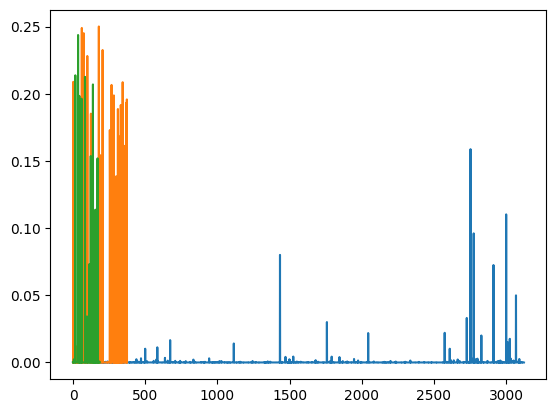

In [23]:
import matplotlib.pyplot as plt
plt.plot(loss_train)
plt.plot(loss_test)
plt.plot(loss_valid)

### Gini index

# Gini = AUC * 2 - 1

Коэффициент Джини вычисляется как двойная площадь между кривой ROC и диагональю (или как Gini = 2AUC - 1). Коэффициент Джини всегда находится между 0 и 1, и чем он больше, тем лучше классификатор. При маловероятном условии, что кривая ROC находится ниже диагонали, коэффициент Джини будет отрицательным.

Чтобы посчитать индекс Gini, нужно сперва определить TP, FP, TN и FN значения (например, на валидационной выборке):


In [49]:
train_set

In [50]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

In [51]:
which_class = 0
actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

/var/folders/95/70q18rsx1b38d6grsdfglfp80000gn/T/ipykernel_36491/1629692295.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  probabilities.extend(np.exp(output[:, which_class]))


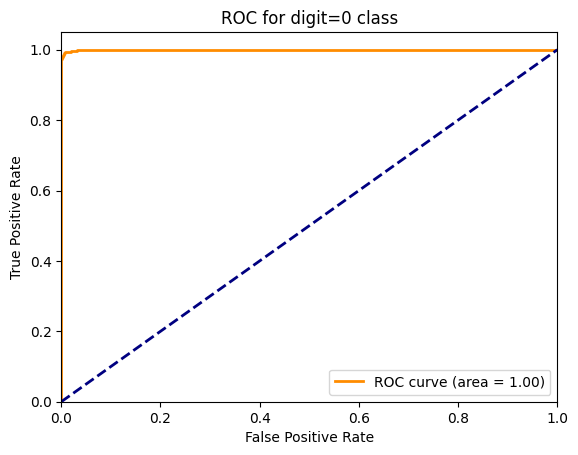

In [ ]:
from sklearn.metrics import auc, roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_sc = roc_auc_score(actuals, class_probabilities)
print(roc_auc_sc)

0.9997621093989809


In [56]:
gini = roc_auc_sc * 2 - 1
print(gini)

0.9995242187979618
